## Set Up
Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from keras import models
from keras import layers
from keras import initializers

Using TensorFlow backend.


### Data generation

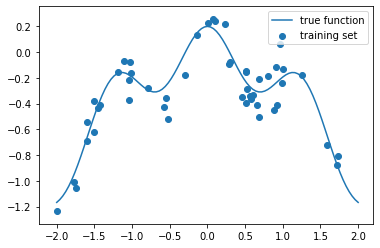

In [3]:
# set seed for reproducibility
np.random.seed(1)

def true_f_ex1(x, a, b):
  return(a*np.cos(5*x) + b*np.square(x))

def sim_data_ex1(n, a, b, sd, seed):
  '''
  A function to randomly generate data with a linear decision boundary
  
  Arguments:
   - n: integer sample size
  
  Return:
   - (x, y) tuple.  x is a numpy array of shape (n, 2) with feature values;
     y is a numpy array of shape (n, 1) with responses (0 or 1)
  '''
  np.random.seed(seed)

  # generate x, n by 1 matrix with observations in rows
  x = 4 * np.random.random((n, 1)) - 2

  # generate y
  y = true_f_ex1(x, a, b) + np.random.standard_normal((n, 1)) * sd

  return((x, y))

# generate training data and plot it
a = 0.2
b = -0.25
sd = 0.15
train_x, train_y = sim_data_ex1(n = 50, a = a, b = b, sd = sd, seed = 986)
val_x, val_y = sim_data_ex1(n = 1000, a = a, b = b, sd = sd, seed = 6315)

# true_function_values
x_grid = np.linspace(-2.0, 2.0, num = 101)
x_grid = x_grid.reshape(1, x_grid.shape[0])
true_f = true_f_ex1(x_grid[0, :], a, b)

# make a plot
plt.plot(x_grid[0, :], true_f, label = "true function")
plt.scatter(train_x[:, 0], train_y[:, 0], label = "training set")
plt.legend(loc = "upper right")
plt.show()

### Utility functions

First function fits a neural network model with specified number of layers and units, relu activations in all hidden layers, and an output layer with one unit and linear activation

Second function plots the activation outputs of all units, by layer.

In [0]:
from keras import backend as K

def fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds):
  model = models.Sequential()

  # add hidden layers
  input_units = [1] + hidden_units
  for (num_units, input_units, b_init_seed, w_init_seed) in zip(hidden_units, input_units, b_init_seeds, w_init_seeds):
    b_initializer = initializers.RandomNormal(seed=b_init_seed)
    w_initializer = initializers.RandomNormal(seed=w_init_seed)
    model.add(layers.Dense(num_units,
        activation = 'relu',
        input_shape = (input_units,),
        bias_initializer = b_initializer,
        kernel_initializer = w_initializer))
  
  # add output layer
  b_initializer = initializers.RandomNormal(seed=b_init_seeds[-1])
  w_initializer = initializers.RandomNormal(seed=w_init_seeds[-1])
  model.add(layers.Dense(1,
      activation = 'linear',
      bias_initializer = b_initializer,
      kernel_initializer = w_initializer))

  # compile and fit model
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  model.fit(train_x, train_y,
    validation_data = (val_x, val_y),
    epochs = 1000,
    batch_size = train_x.shape[0],
    verbose = 0)
  
  return(model)



def plot_layers(model, hidden_legend, include_hidden = True, figsize=(10, 8)):
  if include_hidden:
    num_model_layers = len(model.layers)
  else:
    num_model_layers = 1
  
  fig, axs = plt.subplots(num_model_layers, 1, figsize=figsize)

  # Hidden layers
  if include_hidden:
    for i in range(num_model_layers - 1):
      get_layer_a = K.function([model.layers[0].input], [model.layers[i].output])
      a = get_layer_a([x_grid.T])[0].T

      (w, b) = model.layers[i].get_weights()
      b = b.reshape(b.shape[0], 1)

      for j in range(b.shape[0]):
        axs[i].plot(x_grid[0, :], a[j, :], label = "a" + str(j+1))
      
      if hidden_legend:
        axs[i].legend(ncol = 5)
      
    last_ax = axs[-1]
  else:
    last_ax = axs
  
  # Output layer
  a_output = model.predict(x_grid.T)

  last_ax.plot(x_grid[0, :], true_f, label = "true function")
  last_ax.plot(x_grid[0, :], a_output, label = "estimated function")
  last_ax.scatter(train_x[:, 0], train_y[:, 0], label = "training set")

  plt.show()



def plot_layer_activations_facetted(model, layer_to_plot):
  fig, axs = plt.subplots(8, 4, figsize=(16, 12))

  # Last hidden layer activations, split up
  get_layer_a = K.function([model.layers[0].input], [model.layers[layer_to_plot].output])
  (w, b) = model.layers[layer_to_plot].get_weights()
  b = b.reshape(b.shape[0], 1)

  a = get_layer_a([x_grid.T])[0].T

  for i in range(32):
    plot_row = i % 8
    plot_col = i // 8
    for j in range(32):
      axs[plot_row, plot_col].plot(x_grid[0, :], a[j + i*32, :], label = "a" + str(j+i*32+1))

  plt.show()



def plot_decision_boundary(model_fit, preprocess_x_fn, x1lim, x2lim, gridlen, train_x, train_y):
    '''
    Plot decision boundaries for a Keras model fit with 2 quantitative inputs
    
    Arugments:
     - model_fit: keras model fit
     - preprocess_x_fn: function to preprocess x
     - x1lim: tuple of lower and upper limits for x1
     - x2lim: tuple of lower and upper limits for x2
     - gridlen: how many values of x1 and x2 for which to obtain predictions
     - train_x: n by 2 array of x values for training set
     - train_y: n by 1 array of y values for training set
    '''
    dx1 = (x1lim[1] - x1lim[0])/gridlen
    dx2 = (x2lim[1] - x2lim[0])/gridlen
    background_x0, background_x1 = np.mgrid[slice(x1lim[0], x1lim[1] + dx1, dx1), slice(x2lim[0], x2lim[1] + dx2, dx2)]
    background_x0_long = background_x0[0:gridlen,0:gridlen].reshape((gridlen**2, 1))
    background_x1_long = background_x1[0:gridlen,0:gridlen].reshape((gridlen**2, 1))
    background_x = np.concatenate((background_x0_long, background_x1_long), axis = 1)
    if preprocess_x_fn is not None:
        background_x = preprocess_x_fn(background_x)
    
    yhat_long = (model_fit.predict(background_x) > 0.5)
    yhat = yhat_long.reshape((gridlen, gridlen))

    fig, ax = plt.subplots()
    im = ax.pcolormesh(background_x0, background_x1, yhat, norm = plt.Normalize(-0.2, 1.2), cmap = plt.get_cmap('plasma'), alpha = 0.2, edgecolors = 'none', antialiased = True)
    im = ax.scatter(train_x[:, 0], train_x[:, 1], c = train_y[:, 0], norm = plt.Normalize(-0.2, 1.2), cmap = plt.get_cmap('plasma'))
    plt.show()

### 1 Hidden layer, varying number of units

#### 2 Units
The following fits the same model 3 times with different seeds (basically, different randomly selected initial values for the parameters).

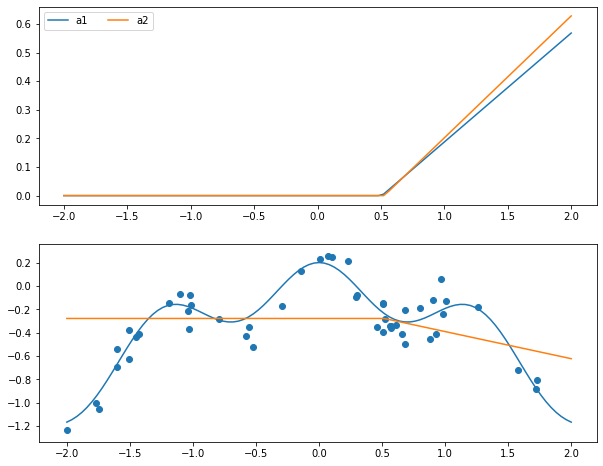

In [301]:
hidden_units = [2]
np.random.seed(87462)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_2units_a = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_2units_a, hidden_legend=True)

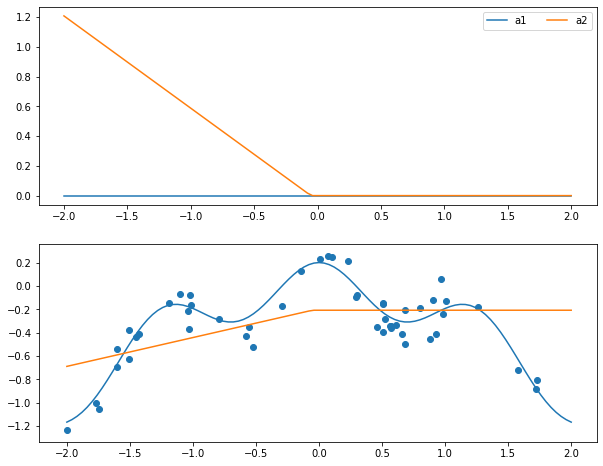

In [0]:
hidden_units = [2]
np.random.seed(874625)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_2units_b = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_2units_b, hidden_legend=True)

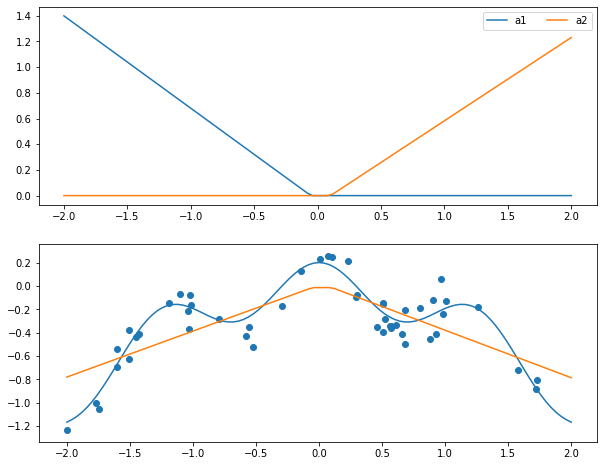

In [0]:
hidden_units = [2]
np.random.seed(8746257)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_2units_c = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_2units_c, hidden_legend=True)

#### 8 units

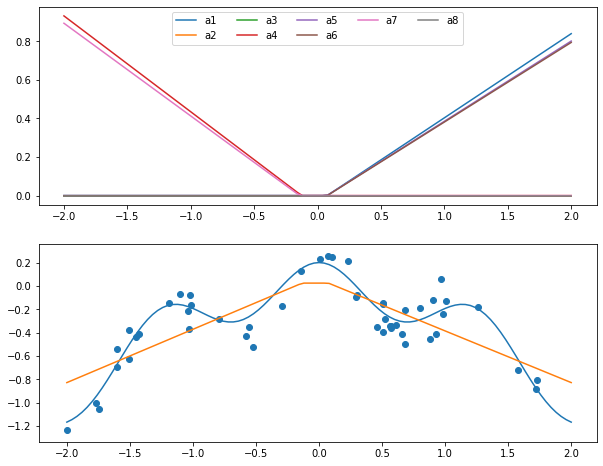

In [0]:
hidden_units = [8]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_8units = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_8units, hidden_legend=True)

### 128 Units

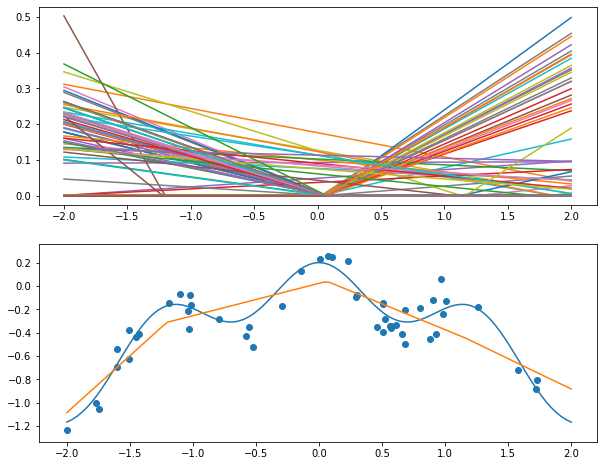

In [0]:
hidden_units = [128]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_128units = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_128units, hidden_legend=False)

### 1024 Units

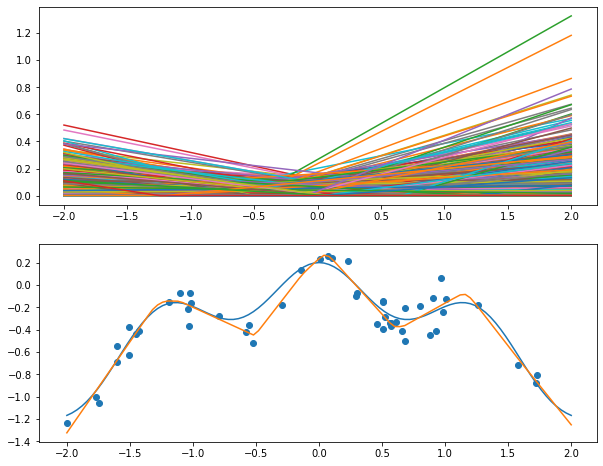

In [0]:
hidden_units = [1024]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_1024units = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_1024units, hidden_legend=False)

### 8192 Units

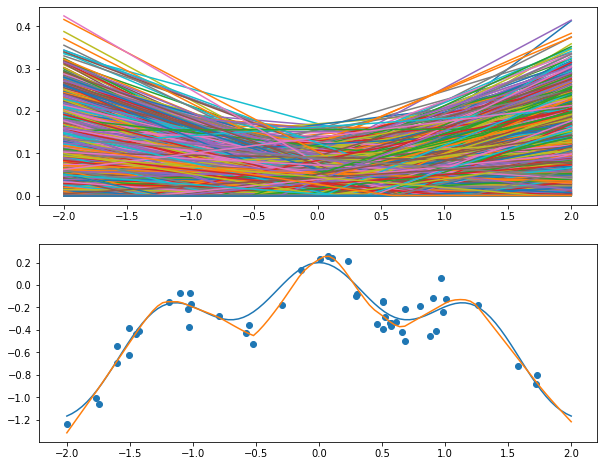

In [0]:
hidden_units = [8192]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_8192units = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_8192units, hidden_legend=False)

### Models with Multiple Hidden Layers, 16 units per layer, relu activation

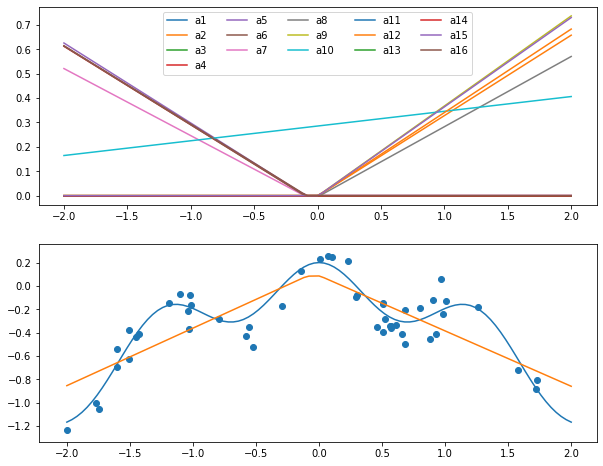

In [0]:
hidden_units = [16]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_1layer = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_1layer, hidden_legend=True)

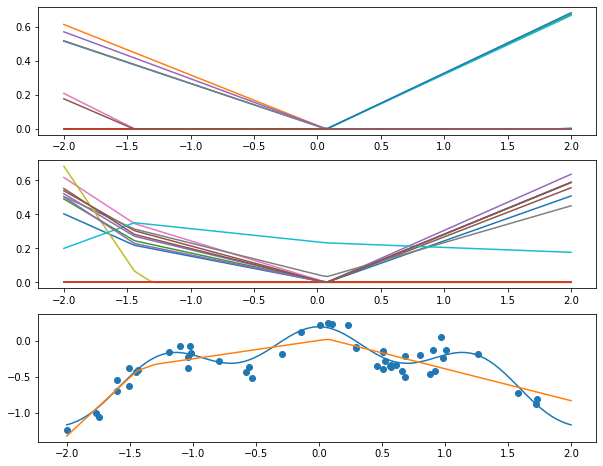

In [0]:
hidden_units = [16, 16]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_2layers = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_2layers, hidden_legend=False)

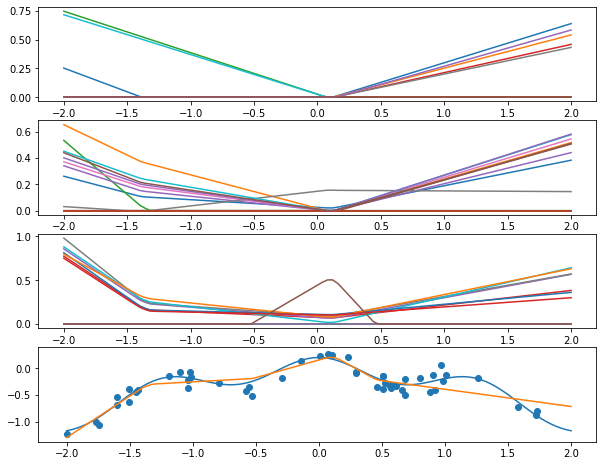

In [0]:
hidden_units = [16, 16, 16]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_3layers = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_3layers, hidden_legend=False)

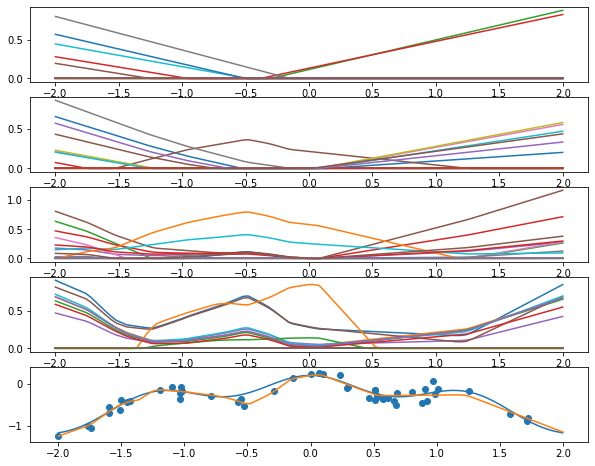

In [0]:
hidden_units = [16, 16, 16, 16]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_4layers = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_4layers, hidden_legend=False)

### Model with so many hidden layers and units


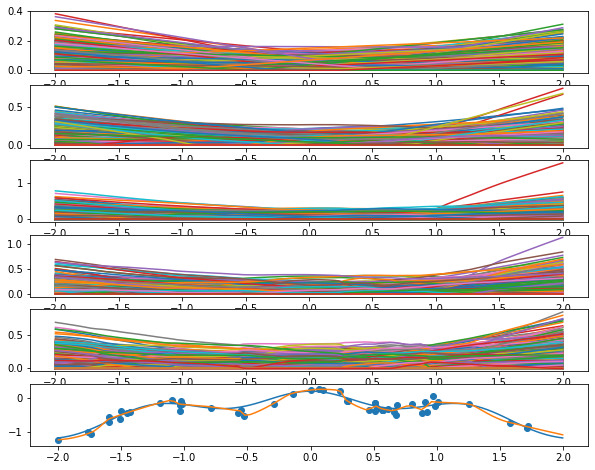

In [17]:
hidden_units = [1024, 1024, 1024, 1024, 1024]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_somany = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_somany, hidden_legend=False)

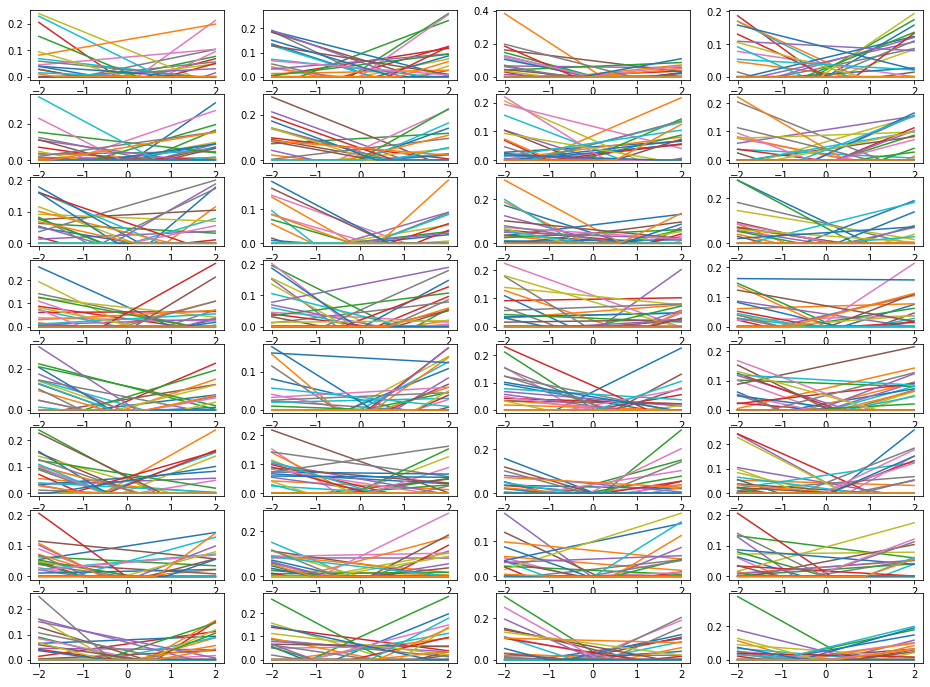

In [0]:
plot_layer_activations_facetted(model_somany, 0)

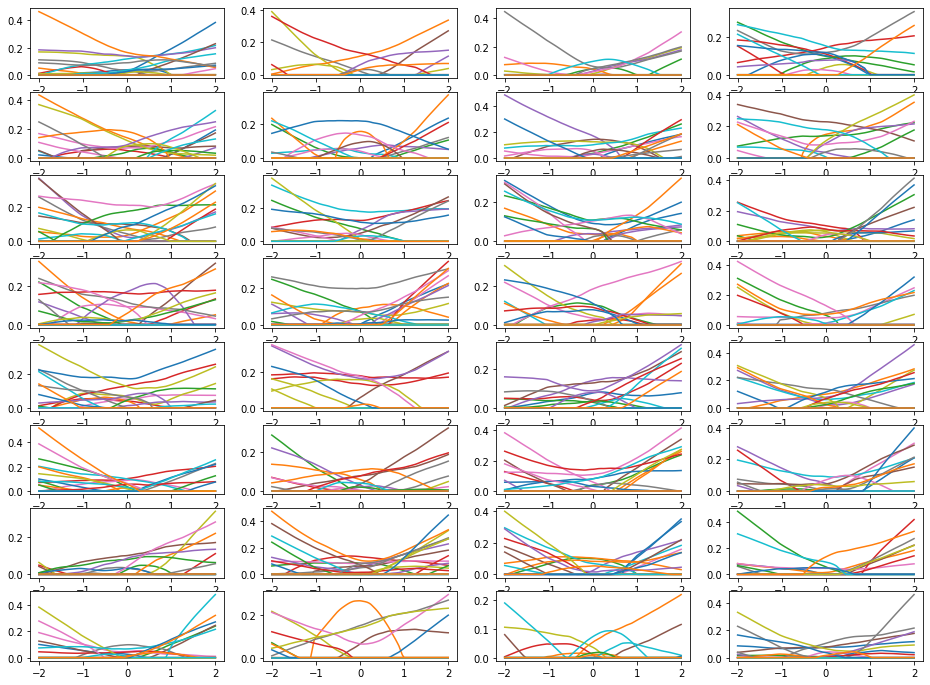

In [0]:
plot_layer_activations_facetted(model_somany, 1)

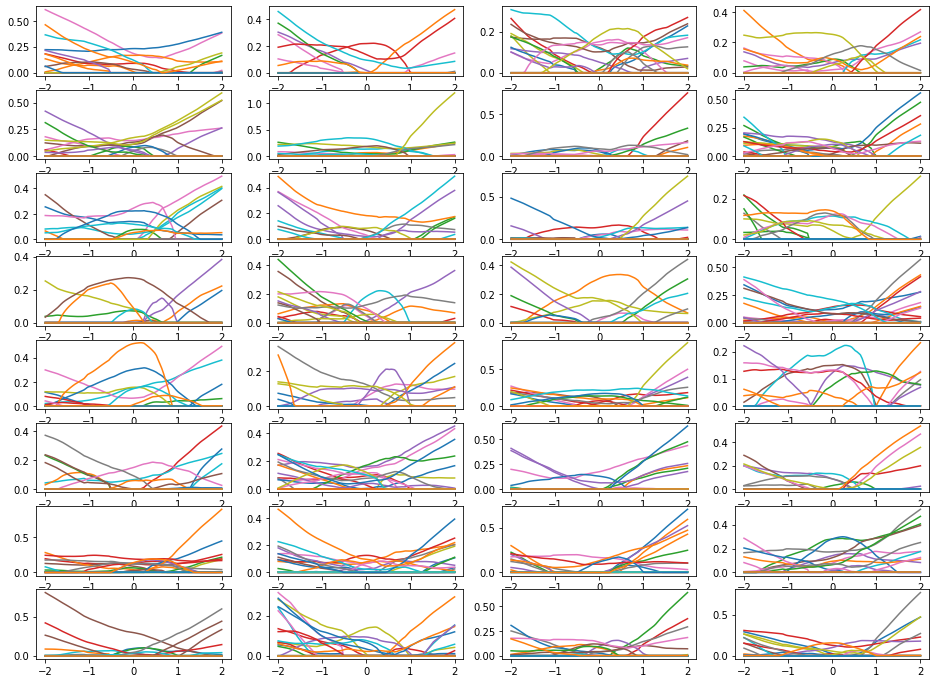

In [0]:
plot_layer_activations_facetted(model_somany, 2)

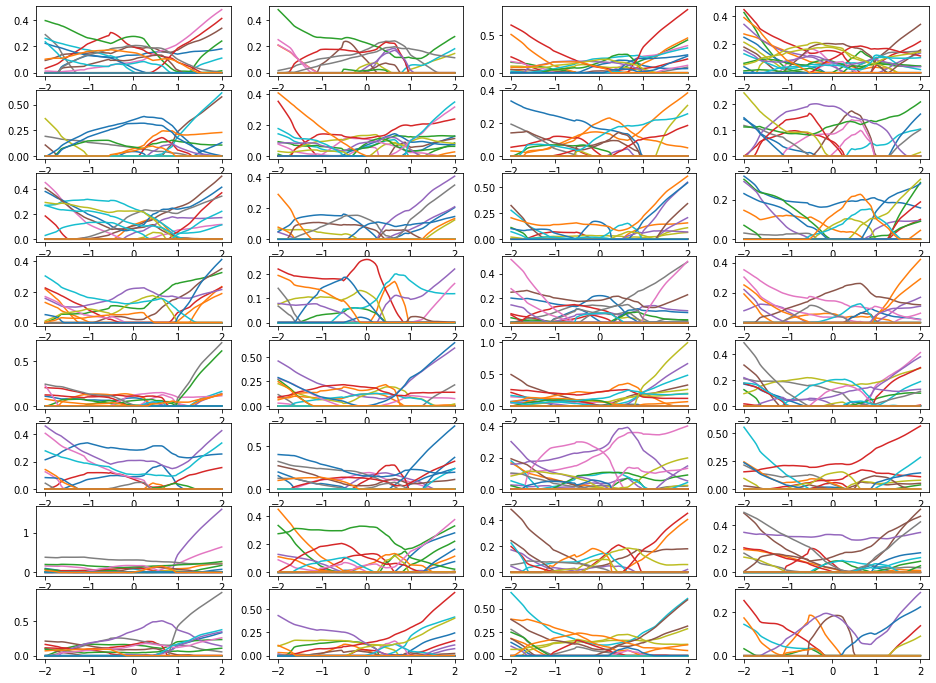

In [0]:
plot_layer_activations_facetted(model_somany, 3)

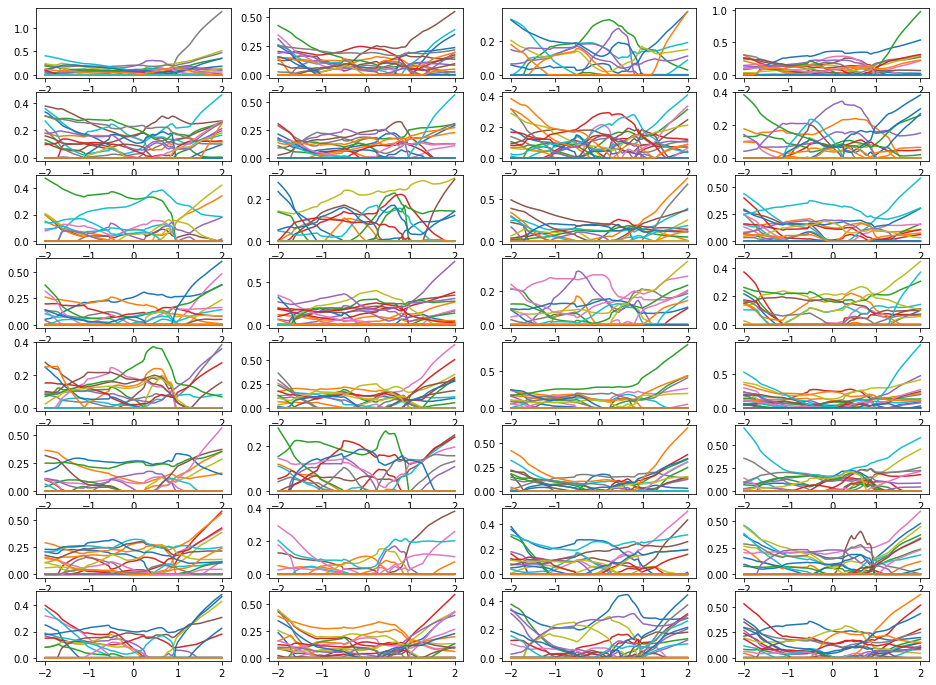

In [309]:
plot_layer_activations_facetted(model_somany, 4)

### How are these models doing in terms of training and validation set performance?

In [310]:
model_names = ['model_2units_c'] + \
  ['model_' + str(j) + 'units' for j in (8, 128, 1024, 8192)] + \
  ['model_1layer'] + \
  ['model_' + str(j) + 'layers' for j in (2, 3, 4)] + \
  ['model_somany']

train_val_scores = pd.DataFrame(index = model_names, columns = ['train_mse', 'val_mse'])

for model_name in model_names:
  model = globals()[model_name]
  train_val_scores.loc[model_name, 'train_mse'] = model.evaluate(train_x, train_y)
  train_val_scores.loc[model_name, 'val_mse'] = model.evaluate(val_x, val_y)

train_val_scores

1000/1000 [==============================] - 0s 62us/step


train_mse    val_mse
model_2units_c    0.0444497  0.0575317
model_8units      0.0427819  0.0535399
model_128units     0.033027  0.0429847
model_1024units  0.00960591  0.0246087
model_8192units  0.00923209  0.0246102
model_1layer      0.0421595  0.0513442
model_2layers     0.0310402  0.0433764
model_3layers     0.0239409  0.0433056
model_4layers     0.0110532  0.0273052
model_somany     0.00613459  0.0296568

### How can we fix up that last model?

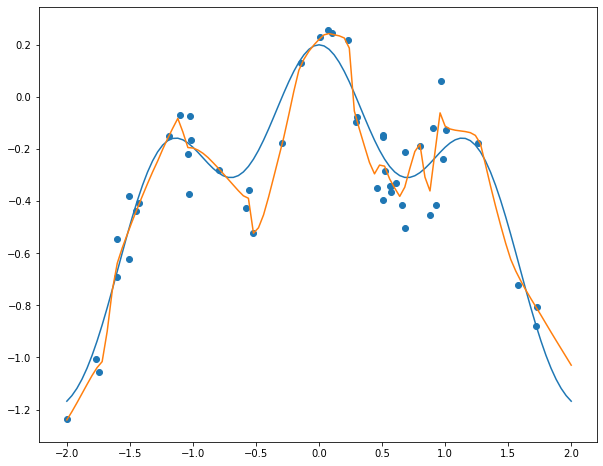

In [311]:
plot_layers(model_somany, hidden_legend=False, include_hidden = False)

In [0]:
(w, b) = model_somany.layers[0].get_weights()
orig_w = w.copy()

In [0]:
change_pt = -b / orig_w
inds_to_fix = np.where(np.logical_and(change_pt >= 0.5, change_pt <= 1.0))
w[inds_to_fix] = orig_w[inds_to_fix] * 0.1

model_somany.layers[0].set_weights((w, b))

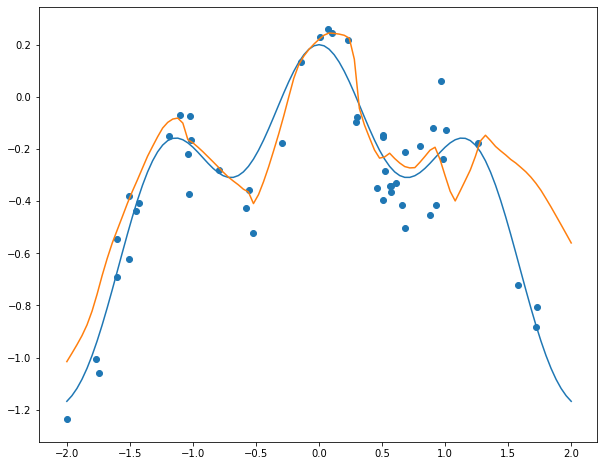

In [314]:
plot_layers(model_somany, hidden_legend=False, include_hidden = False)

### Regularizing the model from the start:
We modify the cost function to be the sum of the negative log likelihood and a penalty on the size of the (squared) weights:

$$J(b, w) = -\ell(b, w) + \sum_{l = 1}^L \lambda_l \left\{ \sum_{i,j} \left(w_{i,j}^{[l]}\right)^2 \right\}$$

 * We want to minimize $J(b, w)$.  Think of this in 2 parts:
    * Minimize negative log-likelihood: want a good fit to the data
    * Minimize penalty terms like $\lambda_l \sum_{i,j} \left(w_{i,j}^{[l]}\right)^2$: weight parameter estimates should not be large.

Note that there is a separate penalty parameter for each layer $l$.

Names for this:

 * $L_2$ Regularization ($L_2$ norm is another name for Euclidean distance, which is based on sums of squares)
 * Penalized estimation
 * Ridge regression
 * Weight decay

### Penalty 0.01 on all layers

Two main changes:

 * `kernel_regularizer=regularizers.l2(penalty)` for each dense layer
 * `metrics = ['mean_squared_error']` when compiling -- note that our cost function now includes penalties and is not a direct measure of validation or test set performance.

In [26]:
# import regularizers
from keras import regularizers

penalty = 0.01

np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = 6)
w_init_seeds = np.random.randint(1, 1e6, size = 6)

regularized_model = models.Sequential()

# add hidden layers
b_initializer = initializers.RandomNormal(seed=b_init_seeds[0])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[0])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    input_shape = (1,),
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[1])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[1])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[2])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[2])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[3])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[3])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[4])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[4])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

# add output layer
b_initializer = initializers.RandomNormal(seed=b_init_seeds[5])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[5])
regularized_model.add(layers.Dense(1,
    activation = 'linear',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

# compile and fit model
regularized_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

regularized_model.fit(train_x, train_y,
  validation_data = (val_x, val_y),
  epochs = 1000,
  batch_size = train_x.shape[0],
  verbose = 0)

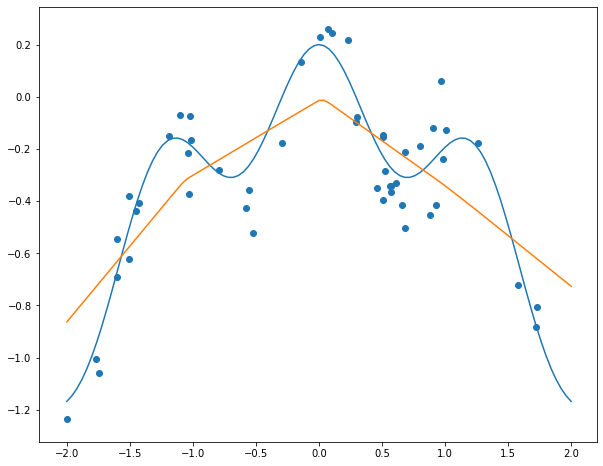

In [27]:
plot_layers(regularized_model, hidden_legend=False, include_hidden = False)

In [28]:
print(regularized_model.evaluate(train_x, train_y))
print(regularized_model.evaluate(val_x, val_y))

50/50 [==============================] - 0s 156us/step
[0.10061833500862122, 0.03954936936497688]
1000/1000 [==============================] - 0s 67us/step
[0.11445685869455338, 0.05338789260387421]


### Penalty 0.001 on all layers

In [23]:
penalty = 0.001

np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = 6)
w_init_seeds = np.random.randint(1, 1e6, size = 6)

regularized_model = models.Sequential()

# add hidden layers
b_initializer = initializers.RandomNormal(seed=b_init_seeds[0])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[0])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    input_shape = (1,),
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[1])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[1])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[2])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[2])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[3])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[3])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[4])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[4])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

# add output layer
b_initializer = initializers.RandomNormal(seed=b_init_seeds[5])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[5])
regularized_model.add(layers.Dense(1,
    activation = 'linear',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

# compile and fit model
regularized_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

regularized_model.fit(train_x, train_y,
  validation_data = (val_x, val_y),
  epochs = 1000,
  batch_size = train_x.shape[0],
  verbose = 0)

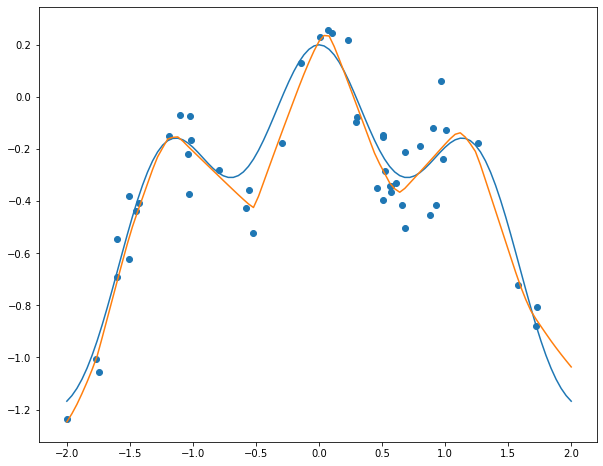

In [24]:
plot_layers(regularized_model, hidden_legend=False, include_hidden = False)

In [25]:
print(regularized_model.evaluate(train_x, train_y))
print(regularized_model.evaluate(val_x, val_y))

50/50 [==============================] - 0s 164us/step
[0.0928116300702095, 0.009383224323391915]
1000/1000 [==============================] - 0s 54us/step
[0.10905261212587357, 0.02562420552968979]


## L1 Regularization

We could also use a penalty based on the absolute values of the weights:

$$J(b, w) = -\ell(b, w) + \sum_{l = 1}^L \lambda_l \left\{ \sum_{i,j} \left\vert w_{i,j}^{[l]}\right\vert \right\}$$

* Change to code relative to above is to use `regularizers.l1(penalty)`

In [31]:
penalty = 0.0001

np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = 6)
w_init_seeds = np.random.randint(1, 1e6, size = 6)

regularized_model = models.Sequential()

# add hidden layers
b_initializer = initializers.RandomNormal(seed=b_init_seeds[0])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[0])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    input_shape = (1,),
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l1(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[1])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[1])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l1(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[2])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[2])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l1(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[3])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[3])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l1(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[4])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[4])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l1(penalty)))

# add output layer
b_initializer = initializers.RandomNormal(seed=b_init_seeds[5])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[5])
regularized_model.add(layers.Dense(1,
    activation = 'linear',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l1(penalty)))

# compile and fit model
regularized_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

regularized_model.fit(train_x, train_y,
  validation_data = (val_x, val_y),
  epochs = 1000,
  batch_size = train_x.shape[0],
  verbose = 0)

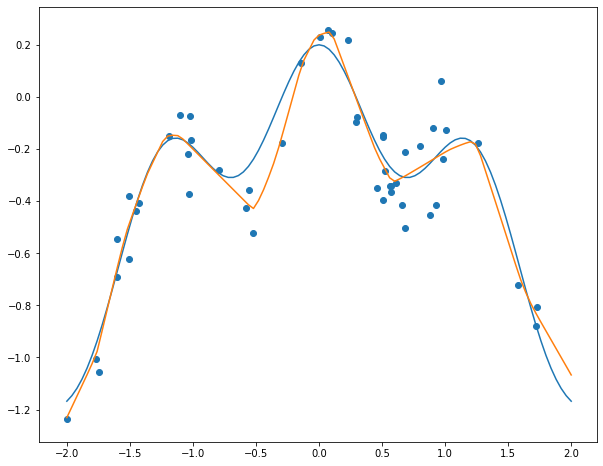

In [32]:
plot_layers(regularized_model, hidden_legend=False, include_hidden = False)

In [33]:
print(regularized_model.evaluate(train_x, train_y))
print(regularized_model.evaluate(val_x, val_y))

50/50 [==============================] - 0s 137us/step
[0.3927127182483673, 0.009438994713127613]
1000/1000 [==============================] - 0s 61us/step
[0.40855745816230776, 0.02528374271094799]


## Classification Example

### Data Generation

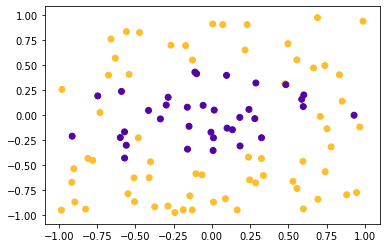

In [58]:
# set seed for reproducibility
np.random.seed(2)

def sim_data_ex2(n):
  '''
  A function to randomly generate data with an elliptical decision boundary
  
  Arguments:
   - n: integer sample size
  
  Return:
   - (x, y) tuple.  x is a numpy array of shape (n, 2) with feature values;
     y is a numpy array of shape (n, 1) with responses (0 or 1)
  '''
  # generate (x1, x2) (observations in rows)
  x = 2 * np.random.random((n, 2)) - 1

  # the model actually uses x^2
  x_squared = x**2

  # parameters
  b = -5
  w = np.array([[5 * 12/9], [5 * 5]])

  # prob of class 1
  p1 = np.exp(b + np.dot(x_squared, w)) / (1 + np.exp(b + np.dot(x_squared, w)))

  # generate y
  y = np.random.binomial(1, p1)

  # return
  return((x, y))

# simulate training data and plot it
(train_x, train_y) = sim_data_ex2(n = 100)

fig, ax = plt.subplots()
scatter = ax.scatter(train_x[:, 0], train_x[:, 1], c = train_y[:, 0], norm = plt.Normalize(-0.2, 1.2), cmap = plt.get_cmap('plasma'))
plt.show()

# simulate test set data to compare models with later
(val_x, val_y) = sim_data_ex2(n = 10000)

### Unpenalized Model

In [51]:
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = 6)
w_init_seeds = np.random.randint(1, 1e6, size = 6)

unregularized_model = models.Sequential()

# add hidden layers
b_initializer = initializers.RandomNormal(seed=b_init_seeds[0])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[0])
unregularized_model.add(layers.Dense(1024,
    activation = 'relu',
    input_shape = (2,),
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[1])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[1])
unregularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[2])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[2])
unregularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[3])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[3])
unregularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[4])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[4])
unregularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

# add output layer
b_initializer = initializers.RandomNormal(seed=b_init_seeds[5])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[5])
unregularized_model.add(layers.Dense(1,
    activation = 'sigmoid',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

# compile and fit model
unregularized_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

unregularized_model.fit(train_x, train_y,
  validation_data = (val_x, val_y),
  epochs = 1000,
  batch_size = train_x.shape[0],
  verbose = 0)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 1024)              3072      
_________________________________________________________________
dense_92 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_93 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_94 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_95 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 1025      
Total params: 4,202,497
Trainable params: 4,202,497
Non-trainable params: 0
___________________________________________

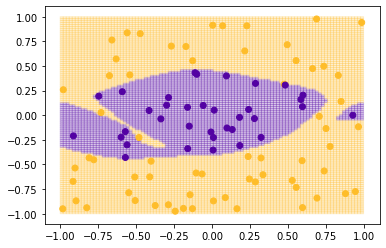

Validation set evaluation:
10000/10000 [==============================] - 1s 52us/step


[1.2083770444512367, 0.88]

In [59]:
unregularized_model.summary()
plot_decision_boundary(unregularized_model, None, (-1, 1), (-1, 1), 101, train_x, train_y)
print("Validation set evaluation:")
unregularized_model.evaluate(val_x, val_y)

### Penalty 0.001

In [61]:
penalty = 0.001

np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = 6)
w_init_seeds = np.random.randint(1, 1e6, size = 6)

regularized_model = models.Sequential()

# add hidden layers
b_initializer = initializers.RandomNormal(seed=b_init_seeds[0])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[0])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    input_shape = (2,),
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[1])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[1])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[2])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[2])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[3])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[3])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[4])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[4])
regularized_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

# add output layer
b_initializer = initializers.RandomNormal(seed=b_init_seeds[5])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[5])
regularized_model.add(layers.Dense(1,
    activation = 'sigmoid',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

# compile and fit model
regularized_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

regularized_model.fit(train_x, train_y,
  validation_data = (val_x, val_y),
  epochs = 1000,
  batch_size = train_x.shape[0],
  verbose = 0)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 1024)              3072      
_________________________________________________________________
dense_110 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_111 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_112 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_113 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 1025      
Total params: 4,202,497
Trainable params: 4,202,497
Non-trainable params: 0
___________________________________________

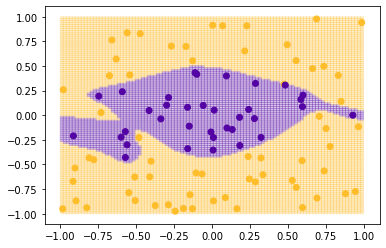

Validation set evaluation:
10000/10000 [==============================] - 1s 63us/step


[0.5694817571163178, 0.8801]

In [62]:
regularized_model.summary()
plot_decision_boundary(regularized_model, None, (-1, 1), (-1, 1), 101, train_x, train_y)
print("Validation set evaluation:")
regularized_model.evaluate(val_x, val_y)

### Penalty 0.01

In [63]:
penalty = 0.01

np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = 6)
w_init_seeds = np.random.randint(1, 1e6, size = 6)

regularized_model_01 = models.Sequential()

# add hidden layers
b_initializer = initializers.RandomNormal(seed=b_init_seeds[0])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[0])
regularized_model_01.add(layers.Dense(1024,
    activation = 'relu',
    input_shape = (2,),
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[1])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[1])
regularized_model_01.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[2])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[2])
regularized_model_01.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[3])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[3])
regularized_model_01.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[4])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[4])
regularized_model_01.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

# add output layer
b_initializer = initializers.RandomNormal(seed=b_init_seeds[5])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[5])
regularized_model_01.add(layers.Dense(1,
    activation = 'sigmoid',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer,
    kernel_regularizer=regularizers.l2(penalty)))

# compile and fit model
regularized_model_01.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

regularized_model_01.fit(train_x, train_y,
  validation_data = (val_x, val_y),
  epochs = 1000,
  batch_size = train_x.shape[0],
  verbose = 0)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 1024)              3072      
_________________________________________________________________
dense_116 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_117 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_118 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_119 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 1025      
Total params: 4,202,497
Trainable params: 4,202,497
Non-trainable params: 0
___________________________________________

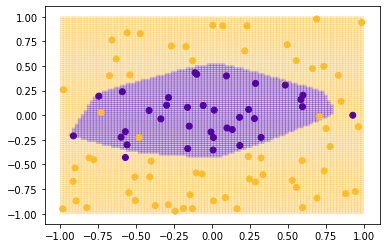

Validation set evaluation:
10000/10000 [==============================] - 1s 62us/step


[0.4293009859085083, 0.9029]

In [64]:
regularized_model_01.summary()
plot_decision_boundary(regularized_model_01, None, (-1, 1), (-1, 1), 101, train_x, train_y)
print("Validation set evaluation:")
regularized_model_01.evaluate(val_x, val_y)